# Examen Práctico

#### 01-3900 | Ciencia de datos | 2025

*Alumnos* :
*   Miro, Agustin
*   Fragassi, Donatella
*   Forestiero, Camila Julieta
*   Martinez, Brenda Carolina
*   Turello, Martina Gloria

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>
BLD: Sangre</BR>
LVL: Hormonales</BR>
REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus.
Dado que el tratamiento es invasivo y la grevedad es moderada se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR>



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos (Sklearn "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html)"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere para finalmente asignar el mejor clasificador o pipeline que usted haya obtenido remplazando en f_clf = None, None por su clasificador o pipeline. Si no utiliza un pipeline, implemente todas las transformaciones entre esa línea y la predicción final.

Persista modelos si realiza procesos que demoren (Mas de 10 minutos es mucho), alternativamente si quiere realizar búsquedas exhaustivas de hiperparametros o variables explicite el procedimiento y luego utilice los valores obtenidos para ajustar un clasificador/regresor y que los tiempos sean posibles en la corrección. Todas las herramientas vistas en clase están disponibles. Verifique que los docentes pueden ejecutar su clasificador / regresor usando el código adjunto y los datos "fuera de la caja" para validar la calidad su modelo.  

En materiales del MIEL/GIT se adjuntan un notebooks con algunas ideas para automatizar el proceso (Pipelines/Transformadores customizados).

# Solucion

### Carga de librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, make_scorer, f1_score, roc_curve, auc

# Importamos distintos clasificadores para comparar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Fijamos semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)

## Lectura del dataset y muestreo
Cargamos el dataset y obtenemos una visión general de la información.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/miroagustin/CienciaDeDatos1Q2025/main/TP_Virus_Alumnos.csv")

# Inspección rápida de las primeras filas
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (4200, 15)


,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
0,9.0,Femenino,36.410602,Inactivo,0,3.139714,6.929112,63.712640,73.880613,15.087239,90.400193,2.015331,1.633836,51.411632,0
1,58.0,Masculino,115.507184,Inactivo,4,2.953914,4.660136,64.582610,73.669319,14.503106,90.817947,0.973317,-0.439358,1000000.000000,0
2,74.0,Masculino,81.249035,Activo,3,1.365200,3.005861,63.613454,75.103984,14.077988,91.741638,3.243344,0.380413,1000000.000000,1
3,NaN,Masculino,77.985589,No_declara,0,2.329285,4.344642,64.433115,73.402436,15.583846,91.741709,3.188290,-0.226046,NaN,0
4,1.0,Femenino,13.446208,Inactivo,0,-0.062975,3.938741,65.122602,75.007982,16.961593,90.668625,2.729202,0.589698,21.627303,1


##  Análisis exploratorio

### Revisión de variables categéricas y numéricas

* Confirmamos con cuántas filas y columnas contamos.
* Revisamos los tipos de datos (numéricos vs. categóricos).

Esto nos ayudará a diseñar las transformaciones (por ejemplo, imputación y escalado para numéricos; OneHotEncoder para categóricos, etc.).

In [3]:
print("Total filas:", df.shape[0])
print("Total columnas (predictoras):", df.shape[1])

print("\nTipos de datos de cada columna:")
display(df.dtypes.value_counts())

print("\nCantidad de variables numéricas vs categóricas:")
display(df.select_dtypes(include=["int64","float64"]).shape[1], "numéricas")
display(df.select_dtypes(include=["object","category"]).shape[1], "categóricas")

Total filas: 4200
Total columnas (predictoras): 15

Tipos de datos de cada columna:


,count
float64,11
object,2
int64,2



Cantidad de variables numéricas vs categóricas:


13

'numéricas'

2

'categóricas'

### Revisión de valores faltantes y nulos

*  Obtenemos el número de nulos por columna y el porcentaje relativo.

* Si alguna columna presenta nulos debemos considerar eliminar los registros, la columna o buscar imputaciones específicas, ya que al probar todos los modelos, muchos de ellos podrían fallar o dar malos resultados porque no soportan nulos.



In [4]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_perc = (missing_counts / df.shape[0]) * 100

df_missing = pd.DataFrame({
    "nulos": missing_counts,
    "pct_nulos": missing_perc.round(2)
}).loc[missing_perc > 0]  # solo se muestran las columnas con > 0% nulos

print("Columnas con valores faltantes:")
display(df_missing)

Columnas con valores faltantes:


,nulos,pct_nulos
Genero,1682,40.05
Edad,822,19.57
LVL,527,12.55


In [5]:
print("Cantidad total de filas:", df.shape[0])
print("Cantidad de filas sin ningún nulo:", df.dropna().shape[0])
print("Porcentaje de filas que conservarías:", round(100 * df.dropna().shape[0] / df.shape[0], 2), "%")

Cantidad total de filas: 4200
Cantidad de filas sin ningún nulo: 1829
Porcentaje de filas que conservarías: 43.55 %


Evaluamos la posibilidad de imputar los nulos y vemos que no es viable. Por lo tanto decidimos imputar de la sigueinte manera:
*   Edad y LVL: imputación con mediana.
*   Genero: imputación con el valor más frecuente.

### Balance de clases
Vemos si la clase “1” (virus) es minoritaria. Dado que se pide “atrapar” el mayor número posible de 1, es probable que enfrentemos un desequilibrio de clases (por ejemplo, muchos ceros y pocos unos).

Esto implica usar estrategias para corregir el sesgo: ajustar class_weight en algunos clasificadores, usar muestreo estratificado, o técnicas de oversampling (SMOTE, etc.) aunque en un entorno de producción hay que tener cuidado con overfitting.

Recuento absoluto por clase:  target
0    2493
1    1707
Name: count, dtype: int64

Porcentaje por clase:  target
0    59.36
1    40.64
Name: count, dtype: float64


<Axes: xlabel='target', ylabel='count'>

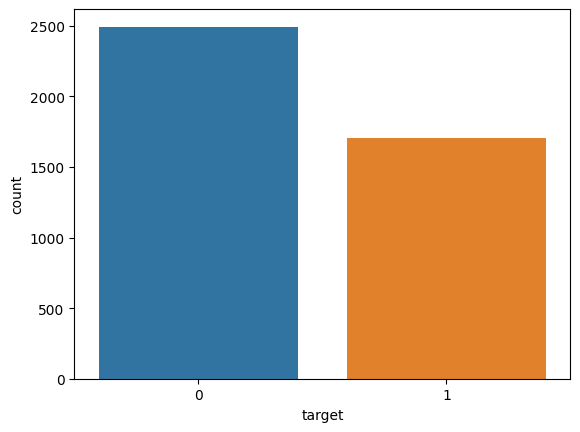

In [6]:
class_counts = df.target.value_counts()
print("Recuento absoluto por clase: ", class_counts)
print("\nPorcentaje por clase: ", (class_counts / len(df.target) * 100).round(2))

sns.countplot(x='target', data=df, hue='target', legend=False)

### Estadísticas descriptivas de variables numéricas
El boxplot nos ayuda a identificar valores atípicos que podrían requerir imputación especial o truncamiento (capping).

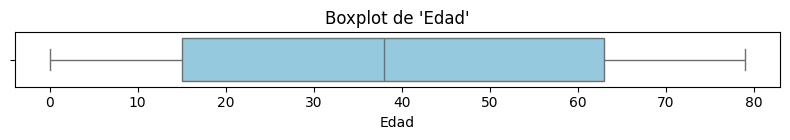

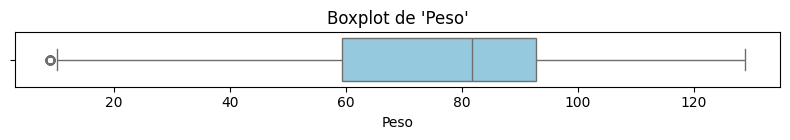

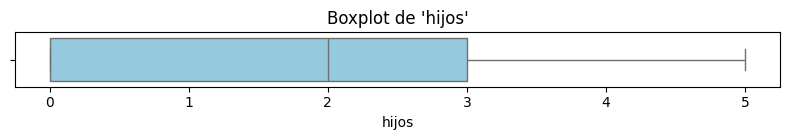

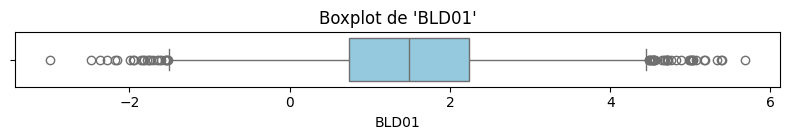

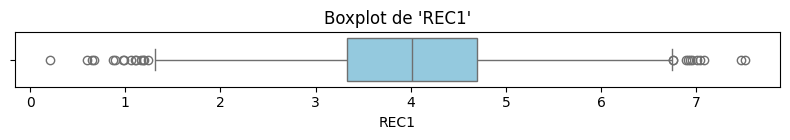

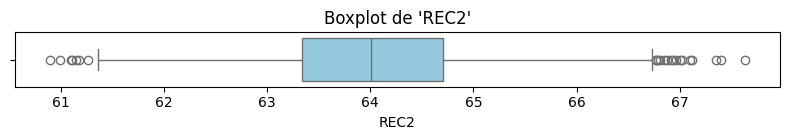

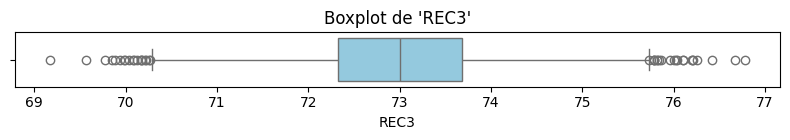

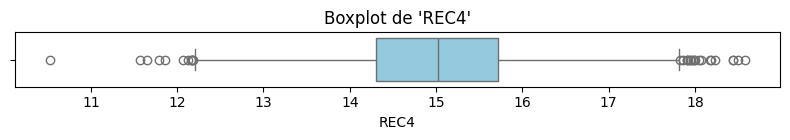

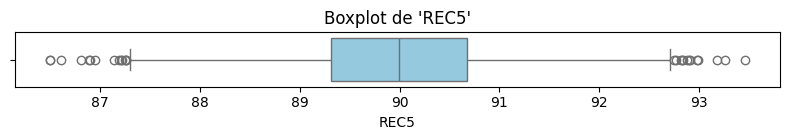

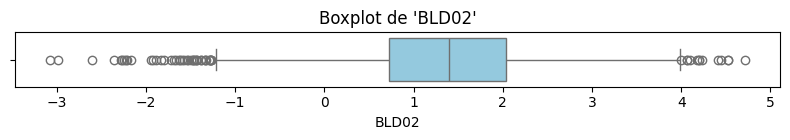

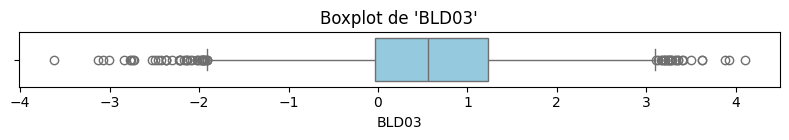

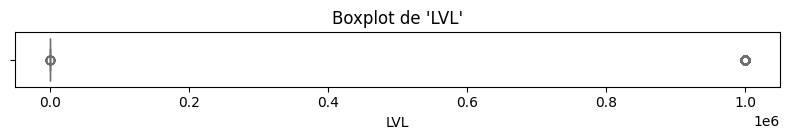

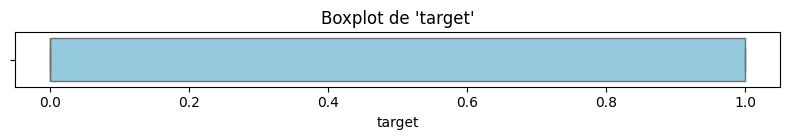

In [7]:
# Variables numéricas
num_vars = df.select_dtypes(include=["int64", "float64"]).columns

# Boxplots individuales
for col in num_vars:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=df[col], color="skyblue", orient="h")
    plt.title(f"Boxplot de '{col}'")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### Correlaciones entre variables numéricas y con el target
Vemos la relación lineal que tienen las variables numéricas con la clase “target”.

Y observamos la matriz de correlación entre todas las variables. Si detectamos variables muy correlacionadas entre sí (por ejemplo, > 0.9), podríamos descartar una para evitar redundancia.

Correlación ABSOLUTA de variables numéricas con target (de mayor a menor):


,target
Peso,0.561041
Edad,0.308114
hijos,0.287858
LVL,0.103897
REC4,0.103096
REC1,0.068830
REC2,0.049570
REC3,0.046991
BLD02,0.010093
REC5,0.005413


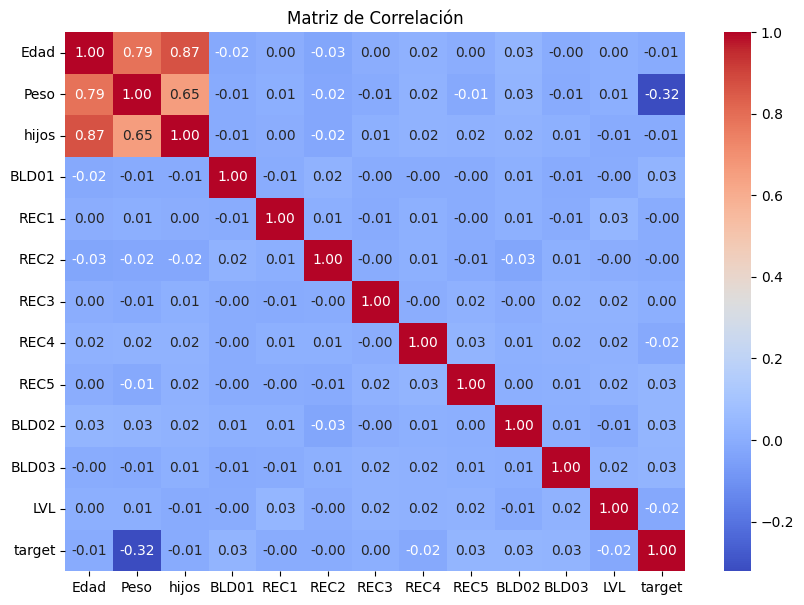

In [8]:
mat = df.select_dtypes(include=['int', 'float']).corr()

# Correlación de todas las variables numéricas con target
corr_target = mat.corr()["target"].abs().sort_values(ascending=False).drop("target")

print("Correlación ABSOLUTA de variables numéricas con target (de mayor a menor):")
display(corr_target)

# Heatmap de correlaciones entre variables numéricas
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

## Preprocesamiento y pipeline básico
En esta sección preparamos las transformaciones que harán falta sobre los datos. La idea es usar un `ColumnTransformer` para separar transformaciones de variables numéricas y categóricas, y luego un pipeline final que contenga:

    1. Imputación (por ejemplo, media/mediana para numéricas; valor más frecuente para categóricas).

    2. Escalado (solo para variables numéricas).

    3. Codificación (One-Hot) para variables categóricas.

    4. Classifier (LogisticRegression, RandomForest, XGBoost, etc.).

### Identificar variables numéricas vs categóricas
Guardamos en listas los nombres de columnas numéricas (num_features) y categóricas (cat_features).

Más adelante las usamos en el ColumnTransformer.

In [9]:
# Partición: 70% para entrenamiento, 30% para evaluación
df_train, df_eval = train_test_split(df, test_size=0.30, stratify=df["target"], random_state=SEED)

X = df.drop(columns="target")
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [10]:
num_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object","category"]).columns.tolist()

print("Variables numéricas:", num_features)
print("Variables categóricas:", cat_features)

Variables numéricas: ['Edad', 'Peso', 'hijos', 'BLD01', 'REC1', 'REC2', 'REC3', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL']
Variables categóricas: ['Genero', 'Laboral']


### Definir transformaciones para columnas numéricas y categóricas
**Imputación:**

    Numéricas → mediana (más robusta frente a outliers).

    Categóricas → la categoría más frecuente.

Se realiza también la imputación de nulos en Edad, LVL y Genero.

**Escalado:** StandardScaler para centrar en 0 y desviación 1.

**OneHotEncoder:** codifica variables categóricas, ignorando categorías nuevas durante la inferencia (handle_unknown="ignore"). Si una variable categórica fuera binaria (solo dos categorías), drop='if_binary' elimina una de ellas para no generar variables linealmente dependientes.

Luego el ColumnTransformer aplicará cada pipeline solo a sus variables correspondientes.

In [23]:
# Para variables numéricas: imputar (mediana si hay outliers), luego escalar (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Nulls en Edad y LVL → se imputan con mediana
    ("scaler", StandardScaler())
])

# Para variables categóricas: imputar la categoría más frecuente, luego OneHotEncoder (drop='if_binary' para evitar multicolinealidad)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Nulls en Genero → se imputan con valor más frecuente
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

# ColumnTransformer para aplicar cada pipeline a las columnas correspondientes
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

## Selección de métrica y estrategia de validación
Dado que queremos “atrapar” la mayor cantidad posible de positivos (clase 1) y al mismo tiempo minimizar falsos positivos, conviene centrarse en:

    Recall de la clase 1 (para no dejar pasar casos con virus).

    Precision de la clase 1 (para no marear con tratamientos invasivos a gente sana).

    O bien una métrica que combine ambos (por ejemplo, F1-score de la clase 1).

Elegimos el F1-Score para la clase positiva ya que balancea precisión y recall, ayudando a detectar la mayor cantidad de casos reales sin generar muchos falsos positivos, lo cual es clave dado que el tratamiento es invasivo pero la gravedad del virus es moderada.

### Definición de scorer personalizado (F1 solo para la clase 1)
make_scorer(f1_score, pos_label=1) nos devuelve un objeto que calcula el F1-score exclusivamente para la clase “1”.

Durante el GridSearchCV, podremos usar este scorer para optimizar hiperparámetros que maximicen F1 en la detección de virus.

In [12]:
f1_class1 = make_scorer(f1_score, pos_label=1)

### Definición de validación cruzada estratificada
Usamos validación cruzada estratificada con 5 pliegues, para mantener la proporción de cada clase en cada fold.

shuffle=True asegura que las muestras se mezclen antes del split; random_state=SEED hace reproducible la división.

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) #42

## Búsqueda de hiperparámetros (GridSearchCV)
Establecemos un pipeline “genérico” donde probamos diferentes clasificadores de los distintos modelos.

In [24]:
# Configuración de pipelines y parámetros para cada modelo
models_and_params = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "clf__n_neighbors": [3, 5, 7],
            "clf__weights": ["uniform", "distance"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10],
            "clf__class_weight": ["balanced", "balanced_subsample"]
        }
    },
    "NaiveBayes": {
        "model": GaussianNB(),
        "params": {
            # GaussianNB apenas requiere ajustar var_smoothing
            "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5],
            "clf__class_weight": ["balanced", None]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, solver="liblinear", max_iter=1000),
        "params": {
            "clf__penalty": ["l1", "l2"],
            "clf__C": [0.1, 1, 10],
            "clf__class_weight": ["balanced", None]
        }
    }
}

In [36]:
# Para cada clasificador: se arma un Pipeline, se hace GridSearchCV y guardan los resultados
best_grids = {}
results = []

for name, mp in models_and_params.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", mp["model"])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=mp["params"],
        scoring=f1_class1,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    print(f"\n--- Ajustando {name} ---")
    grid.fit(X_train, y_train)

    print(f"Mejores parámetros para {name}: {grid.best_params_}")
    print(f"Mejor F1 (clase 1) para {name}: {grid.best_score_:.4f}\n")

    results.append({
        "Modelo": name,
        "Best_F1_1": grid.best_score_,
        "Best_Params": grid.best_params_
    })

    # Guardamos el GridSearch para ese modelo
    best_grids[name] = grid


--- Ajustando KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros para KNN: {'clf__n_neighbors': 7, 'clf__weights': 'distance'}
Mejor F1 (clase 1) para KNN: 0.6263


--- Ajustando RandomForest ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parámetros para RandomForest: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__n_estimators': 200}
Mejor F1 (clase 1) para RandomForest: 0.7275


--- Ajustando NaiveBayes ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejores parámetros para NaiveBayes: {'clf__var_smoothing': 1e-09}
Mejor F1 (clase 1) para NaiveBayes: 0.5717


--- Ajustando DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros para DecisionTree: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__min_samples_split': 2}
Mejor F1 (clase 1) para DecisionTree: 0.6857


--- Ajustando LogisticRegression ---
Fitting 5 folds for each of 12 candid

## Comparación de resultados y elección del mejor modelo
Tras ejecutar GridSearchCV, comparamos las mejores puntuaciones (best_score_) de cada uno.

Decidimos quedarnos con el modelo que maximice F1 en la clase 1 (que captura mejor el compromiso entre precision y recall para detectar virus).

Si hubiera dos modelos con valores muy cercanos, podríamos comparar sus curvas de precision-recall o incluso medir roc_auc_score.

In [16]:
results_df = pd.DataFrame(results).sort_values(by="Best_F1_1", ascending=False)
print("=== Resumen comparativo de F1 (clase 1) ===")
display(results_df)

=== Resumen comparativo de F1 (clase 1) ===


,Modelo,Best_F1_1,Best_Params
1,RandomForest,0.727539,"{'clf__class_weight': 'balanced_subsample', 'c..."
3,DecisionTree,0.685716,"{'clf__class_weight': None, 'clf__max_depth': ..."
4,LogisticRegression,0.681004,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl..."
0,KNN,0.626258,"{'clf__n_neighbors': 7, 'clf__weights': 'dista..."
2,NaiveBayes,0.571747,{'clf__var_smoothing': 1e-09}


## Evaluación del modelo sobre el conjunto test

In [43]:
grid_rf = best_grids["RandomForest"]        # se guarda el clasificador con mejor score, junto con sus parametros y las columnas seleccionadas
best_clf = grid_rf.best_estimator_          # se guarda en best_clf

In [45]:
y_pred = best_clf.predict(X_test)
print("Reporte de clasificación final (muestra evaluación):")
print(classification_report(y_test, y_pred, digits=4))

Reporte de clasificación final (muestra evaluación):
              precision    recall  f1-score   support

           0     0.7916    0.8583    0.8236       748
           1     0.7639    0.6699    0.7138       512

    accuracy                         0.7817      1260
   macro avg     0.7778    0.7641    0.7687      1260
weighted avg     0.7804    0.7817    0.7790      1260



## Analizar curvas Precision–Recall y ROC
Utilizamos las curvas ROC y Precision–Recall (PR) para evaluar el rendimiento del modelo más profundamente, especialmente en lo que respecta a la capacidad de distinguir la clase positiva.

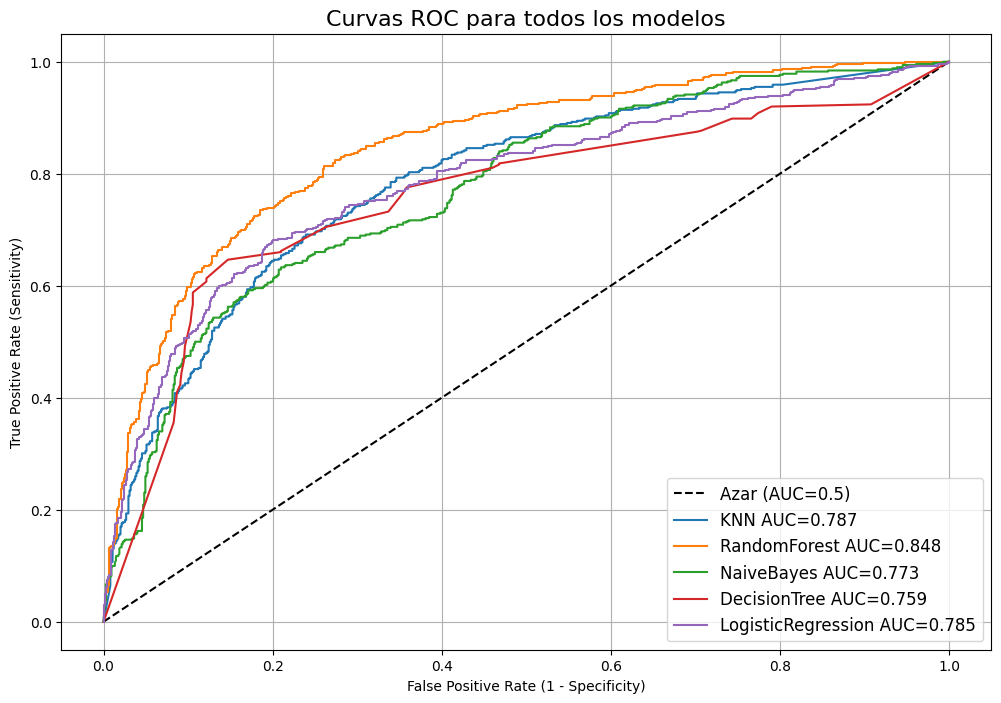

               Modelo       AUC
1        RandomForest  0.847813
0                 KNN  0.787043
4  LogisticRegression  0.785052
2          NaiveBayes  0.772799
3        DecisionTree  0.758867


In [46]:
# Curva ROC
def graficarCurvaRoc(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} AUC={roc_auc:.3f}")
    return roc_auc

plt.figure(figsize=(12,8))
plt.plot([0,1], [0,1], 'k--', label="Azar (AUC=0.5)")

areas = []

for modelo_name, grid in best_grids.items():
    best_clf = grid.best_estimator_

    y_proba = best_clf.predict_proba(X_test)[:,1]

    auc_score = graficarCurvaRoc(y_test, y_proba, modelo_name)
    areas.append((modelo_name, auc_score))

areas_df = pd.DataFrame(areas, columns=['Modelo', 'AUC'])

plt.title("Curvas ROC para todos los modelos", fontsize=16)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print(areas_df.sort_values(by="AUC", ascending=False))

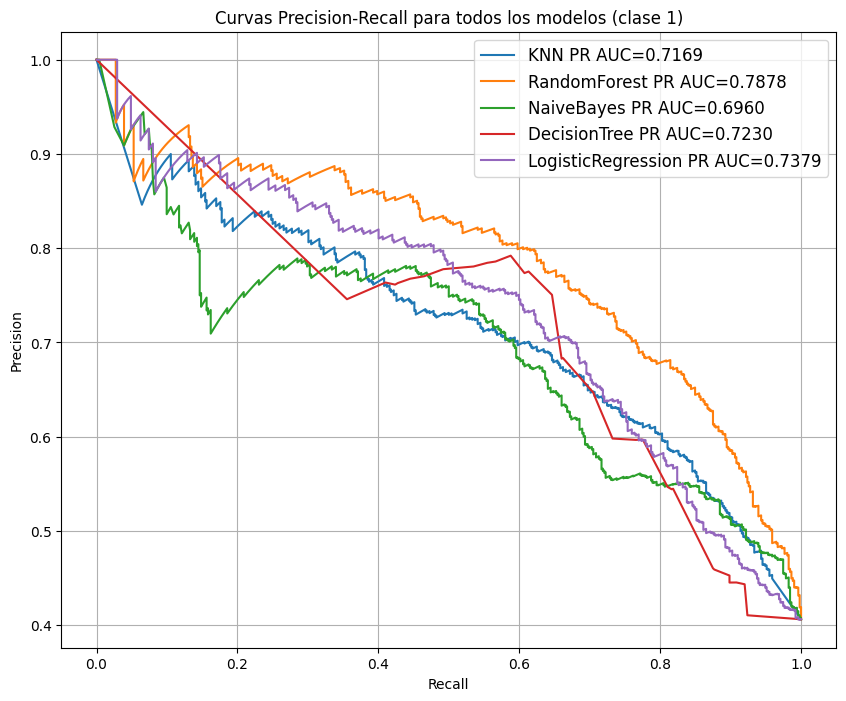

In [42]:
# Curva Precision–Recall
plt.figure(figsize=(10,8))

for modelo_name, grid in best_grids.items():
    best_clf = grid.best_estimator_

    # Probabilidades para clase 1
    y_scores = best_clf.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label=1)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f"{modelo_name} PR AUC={pr_auc:.4f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall para todos los modelos (clase 1)")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Evaluación final sobre el conjunto de evaluación “out-of-the-box”

### Reentrenamiento con todo el set (modo NO producción)
Reentrenamos el modelo con todo el dataset original (TP_Virus_Alumnos.csv), usando los mejores hiperparámetros encontrados. Así tenemos el modelo “definitivo” antes de evaluarlo “fuera de caja”.

In [20]:
# Carga completa del dataset original
df_full = pd.read_csv("https://raw.githubusercontent.com/miroagustin/CienciaDeDatos1Q2025/main/TP_Virus_Alumnos.csv")
X_full = df_full.drop("target", axis=1)
y_full = df_full["target"]

# grid_rf.best_estimator_ es el pipeline entrenado con los mejores hiperparámetros ya aplicados
grid_rf.best_estimator_.fit(X_full, y_full) # se reentrena con todo el dataset
best_clf = grid_rf.best_estimator_          # se guarda en best_clf

Ahora que tenemos el mejor modelo (best_clf), lo reentrenamos con todo el dataset para que posteriormente al ser usado en producción haya sido entrenado con una mayor cantidad de datos.

##Como Guardar modelo

Si el modelo tarda más de 10 minutos en entrenar, conviene guardarlo con joblib o pickle. Esto permite recargarlo sin volver a ajustarlo. Se realiza de la siguiente manera:
```
import joblib

# Nombre de archivo donde persistiremos el pipeline
joblib.dump(best_clf, "best_clf_virus.pkl")
print("Modelo guardado en best_clf_virus.pkl")
```
Con joblib.dump, se guarda el Pipeline completo (incluye preprocesamiento y clasificador).

Si más adelante se lo queiere usar, se puede de la siguiente manera:

    loaded_clf = joblib.load("best_clf_virus.pkl")
    y_pred_new = loaded_clf.predict(X_new)

En este caso, el modelo no tarda en entrenar, por lo que, no hace falta guardarlo, pero se podría realizar

---

# Evaluacion final - Docente + Alumno

Enunciado:

In [21]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

PRODUCCION = False
best_clf = best_clf #Asignar aqui el mejor clasificador/pipeline posible (previamente entrenado si es necesario)

#Leemos el dataset de evaluación, simulando producción
if PRODUCCION==False:
    df = pd.read_csv("https://raw.githubusercontent.com/miroagustin/CienciaDeDatos1Q2025/main/TP_Virus_Alumnos.csv")
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")
#Dividimos en target y predictoras

X_prod = df.drop("target", axis=1)
y_prod = df["target"]

#Transformaciones en caso de no ser un pipeline completo. Preferiblemente, el mejor pipeline debe incluir todas las transformaciones necesarias.
#Si es pipeline ejecutar el fit (tener en cuenta el tiempo). Si mediante exploración / busqueda exhaustiva se encontró el mejor clasificador
#harcodear sus hiperparametros (Adjuntar código y explicación de como se encontró el mejor clasificador).

#Evaluación final
y_pred = best_clf.predict(X_prod)
print(classification_report(y_prod, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       739
           1       0.93      0.80      0.86       521

    accuracy                           0.89      1260
   macro avg       0.90      0.88      0.89      1260
weighted avg       0.90      0.89      0.89      1260



Fin del enunciado

---